# Lesson 2: Residence time distributions

The residence time is a measure of the time material spends in a volume through which it flows. Molecules or small volume elements have a single residence time, but more complex systems have a characteristic residence time distribution (RTD).

### System Theory
Basic residence time theory treats a system with an input and an output. The residence time of a small particle is the time between entering and leaving the system.  

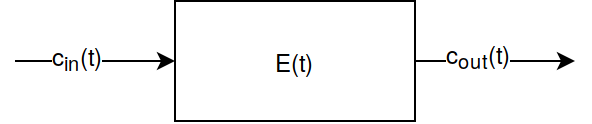

The residence time distribution can be described with the function $E(t)$ which has the properties of a probability distribution:  
$$E(t) \ge 0~\text{and}~\int_0^\infty E(t)~dt = 1$$  

### Determining the RTD experimentally

Residence time distributions are measured by introducing a non-reactive tracer into the system at the inlet:  
1. Change input concentration according to a known function (e.g. Dirac $\delta$-function or step function)
2. Measure output concentration  
3. Transform output concentration in residence time distribution curve $E(t)$


For some simple systems (e.g. CSTR and Plug flow reactor model) analytic solutions exist and we can compare them with the simulations of CADET. 

**In this lesson, we will:**
- Learn about system responses.
- Setup our first 'real' unit operation models.
- Analyze the solution and take a look 'inside' a column.

## Example 1: Continuous stirred-tank reactor

In an ideal continuous stirred-tank reactor (CSTR), the flow at the inlet is completely and instantly mixed into the bulk of the reactor. The reactor and the outlet fluid have identical, homogeneous compositions at all times. The residence time distribution is exponential:

$$E(t) = \frac{1}{\tau} \cdot e^{-\frac{t}{\tau}}$$

with 

$$\tau = \frac{V}{Q}$$

<div class="alert alert-info">

**Note:** 

In reality, it is impossible to obtain such rapid mixing, especially on industrial scales where reactor vessels may range between 1 and thousands of cubic meters, and hence the RTD of a real reactor will deviate from the ideal exponential decay.

</div>

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [ ]:
%run ../utils.ipynb

## CSTR model

The `CSTR` [model](https://cadet.github.io/modelling/unit_operations/cstr.html#cstr-model) in CADET requires the following [parameters](https://cadet.github.io/interface/unit_operations/cstr.html#cstr-config):
- Initial volume `init_volume`
- Initial concentration `init_c`

In later examples, we will also associate [adsorption models](https://cadet.github.io/modelling/binding/index.html) and [chemical reactions](https://cadet.github.io/modelling/reactions.html) with the `CSTR` unit operation. For this example, however, we will only consider convective flow.

In [ ]:
n_comp = 1
tau = 1
V = 1

model = get_cadet_template(n_units=3)

# Unit Operations
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

## CSTR
model.root.input.model.unit_001.unit_type = 'CSTR'
model.root.input.model.unit_001.ncomp = n_comp
model.root.input.model.unit_001.init_volume = V
model.root.input.model.unit_001.init_c = [0.0]

### Adsorption model
model.root.input.model.unit_001.adsorption_model = 'NONE'

## Outlet
model.root.input.model.unit_002.unit_type = 'OUTLET'
model.root.input.model.unit_002.ncomp = 1

# Connections
model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, V/tau,
    1, 2, -1, -1, V/tau,
]

### Pulse experiment CSTR

This method requires the introduction of a very small volume of concentrated tracer at the inlet of a CSTR, such that it approaches the Dirac $\delta$-function.
By definition, the integral of this function is equal to one.
Although an infinitely short injection cannot be produced, it can be made much smaller than the mean residence time of the vessel. 

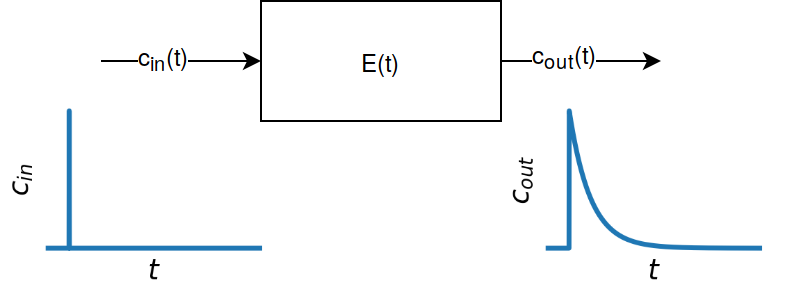

In [ ]:
step_size = 1e-3

# Create Step
model.root.input.model.unit_000.sec_000.const_coeff = [1/step_size,]
model.root.input.model.unit_000.sec_001.const_coeff = [0.0,]

## Sections and Switches
model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, step_size, 10]
model.root.input.solver.sections.section_continuity = [0,]

model = run_simulation(model)

plt.figure()

time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_inlet
plt.plot(time, c)
plt.title('CSTR (Inlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()

time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.title('CSTR (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()

## Example 2: Plug flow reactor

In an ideal plug flow reactor the fluid elements that enter at the same time continue to move at the same rate and leave together. 
Therefore, fluid entering at time $t$ will exit at time $t + \tau$, where $\tau$ is the residence time. 
The fraction leaving is a step function, going from $0$ to $1$ at time $\tau$.
The distribution function is therefore a Dirac delta function at $\tau$.

$$E(t) = \delta (t - \tau)$$


The RTD of a real reactor deviates from that of an ideal reactor, depending on the hydrodynamics (e.g. the axial dispersion) within the vessel.

## PFR model

Although in CADET there is no explicit implementation of the PFR model, we can still model this reactor if we use any of the column models and set the porosity to 1 and the axial dispersion to 0.

In this example, we will use the `LUMPED_RATE_MODEL_WITHOUT_PORES`. For the model equations see [here](https://cadet.github.io/modelling/unit_operations/lumped_rate_model_without_pores.html) and the parameters [here](https://cadet.github.io/interface/unit_operations/lumped_rate_model_without_pores.html). The following parameters need to be specified:

- Column length `col_length`
- Interstitial velocity `velocity`
- Total porosity `total_porosity`
- Axial dispersion `col_dispersion`
- Initial concentration `init_c`

<div class="alert alert-info">

**Note:** 

As an alternative to the interstitial velocity, it is also possible to specify the cross section area of the column.

</div>

In [ ]:
n_comp = 1
tau = 5
length = 1

model = get_cadet_template(n_units=3)

# Unit Operations
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# Tubular reactor
model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
model.root.input.model.unit_001.ncomp = n_comp
model.root.input.model.unit_001.col_length = length
model.root.input.model.unit_001.velocity = length/tau
model.root.input.model.unit_001.total_porosity = 1
model.root.input.model.unit_001.col_dispersion = 0
model.root.input.model.unit_001.init_c = [0.0]

### Adsorption model
model.root.input.model.unit_001.adsorption_model = 'NONE'

## Outlet
model.root.input.model.unit_002.unit_type = 'OUTLET'
model.root.input.model.unit_002.ncomp = 1

# Connections
model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 1,
    1, 2, -1, -1, 1,
]

### Discretization

In case of the column, we also need to provide parameters for [discretization](https://cadet.github.io/interface/unit_operations/lumped_rate_model_without_pores.html#group-input-model-unit-xxx-discretization-unit-type-lumped-rate-model-without-pores)

There are several options for adapting the spatial discretization of the PDE model. However, the two most important ones are the number of grid cells in the column (axial direction) and the particles. Since the lumped rate model without pores does not have particles, we only need to specify axial cells `ncol` and set them to 20.



<div class="alert alert-danger">

**Warning:** 

These are rather low values to make the examples run faster, since they are only for educational purposes. In practice, much higher values are expected (say 100-200 axial cells and 16-32 particle cells). Note that the WENO scheme, which handles the advection, drastically reduces the required amount of cells compared to an upwind scheme.

</div>



In [ ]:
# Grid cells
model.root.input.model.unit_001.discretization.ncol = 20

# Bound states
model.root.input.model.unit_001.discretization.nbound = n_comp*[0.0]

# Other options
model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
model.root.input.model.unit_001.discretization.gs_type = 1
model.root.input.model.unit_001.discretization.max_krylov = 0
model.root.input.model.unit_001.discretization.max_restarts = 10
model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

# Weno options
model.root.input.model.unit_001.discretization.weno.boundary_model = 0
model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
model.root.input.model.unit_001.discretization.weno.weno_order = 3

In [ ]:
step_size = 1e-3

# Create Step
model.root.input.model.unit_000.sec_000.const_coeff = [1/step_size,]
model.root.input.model.unit_000.sec_001.const_coeff = [0.0,]

## Sections and Switches
model.root.input.solver.sections.nsec = 2
model.root.input.solver.sections.section_times = [0.0, step_size, 10]
model.root.input.solver.sections.section_continuity = [0,]

model = run_simulation(model)

plt.figure()

time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_000.solution_outlet
plt.plot(time, c)
plt.title('Column (Inlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()

time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_outlet
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()

<div class="alert alert-danger">

**Warning:** 

Because of numerical dispersion, solvers like CADET are not suited to simulate stiff systems like the one presented. 
To get a more acurate solution, the number of axial cells needs to be increased (a lot) which also increases simulation time (a lot).
Since usually there is some (physical) dispersion in real systems anyway, mostly this is not a problem because it will smoothen the profiles anyway.
The example just serves to show the limitations of CADET and that while it may not be very accurate in this case, the value of the mean residence time is still where we would expect it.
    
</div>



## Visualization

Additionally to the solution at the inlet and outlet of a unit operation, we can also take a look inside. 

Again we find the solution in the `/output/solution/unit_XXX` group. 
Additionally, we find the coordinates of a column in `/output/coordinates/unit_XXX/axial_coordinates`

In [ ]:
ymax = np.max(model.root.output.solution.unit_001.solution_bulk[:])
solution = model.root.output.solution.unit_001.solution_bulk
coordinates = model.root.output.coordinates.unit_001.axial_coordinates

def graph_column(time=0):
    plt.figure(figsize=[15,5])
    plt.plot(coordinates, solution[time, :, 0])
    plt.ylim(0, ymax)
    plt.xlabel('Column Length')
    plt.ylabel('Concentration (mM)')

style = {'description_width': 'initial'}
interact(graph_column, time=widgets.IntSlider(min=0, max=len(model.root.output.solution.solution_times) -1, step=10, layout={'width': '800px'}, style=style, description='Time'))